In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from keras.models import load_model
import tensorflow as tf
import numpy as np
import os
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from keras.layers import Activation, Dropout, Dense

In [61]:
url = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(url, trainable=False),
])
feature_model.build([None, 224, 224, 3])
feature_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   multiple                  23561152  
Total params: 23,561,152
Trainable params: 0
Non-trainable params: 23,561,152
_________________________________________________________________


In [73]:
batch_size= 24
train_datagen = ImageDataGenerator(rescale=1./255
                                   , rotation_range=0.05
                                   , horizontal_flip=True
                                   , validation_split=0.20)

root_dir = 'D:/marytalk/data/resized/images'
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)
train_generator = train_datagen.flow_from_directory(
     root_dir, subset='training', batch_size=batch_size, seed=10
    , shuffle=True, class_mode='categorical'
    , target_size=(224,224))
valid_generator = valid_datagen.flow_from_directory(
    root_dir, subset='validation', batch_size=1, seed=10
    , shuffle=True, class_mode='categorical'
    , target_size=(224,224))

Found 4454 images belonging to 20 classes.
Found 1105 images belonging to 20 classes.


In [74]:
train_generator.class_indices

{'as_perm': 0,
 'baby_perm': 1,
 'balon_perm': 2,
 'bob_cut': 3,
 'buzz_cut': 4,
 'c_curl_perm': 5,
 'chuffybang': 6,
 'crop_cut': 7,
 'dandy_cut': 8,
 'dreadlocks': 9,
 'foil_perm': 10,
 'glam_perm': 11,
 'hippie_perm': 12,
 'hush_cut': 13,
 'layered_cut': 14,
 'mohican': 15,
 'part_perm': 16,
 'pomade': 17,
 'wave_perm': 18,
 'wolf_cut': 19}

In [75]:
batch_step = (train_generator.n*3)//batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0 :
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)

    feature = feature_model.predict(x)
    train_features.extend(feature)

train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0 :
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)

    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
(13324, 2048)
(13324, 20)
0
100
200
300
400


C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag)
C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)


500
600
700
800
900
1000
1100
(1105, 2048)
(1105, 20)


In [96]:
# 모델 저장
MODEL_DIR ='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath='./model/20-resnet-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath,monitor='val_loss',verbose=1,save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10)



with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(256, activation='selu', input_shape=(2048,)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='selu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='selu'))
    model.add(Dropout(0.5))
    model.add(Dense(20))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.build([224, 224, 3])
    model.summary()

    history = model.fit(train_features, train_Y, 
                        class_weight='balanced',
                        validation_data=(valid_features, valid_Y), 
                        epochs=50, batch_size=5,
                        verbose=1,callbacks=[early_stopping_callback,checkpointer])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 20)              

In [90]:
model.save('model/5_20_256_selu_selu_selu_sigmoid_resnet_class.h5')

with tf.device('/GPU:0'):
    model = Sequential([
                      Dense(256, activation='relu', input_shape=(2048,)),
                      Dropout(0.5),
                      Dense(15, activation='softmax')
    ]) 

    model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()

    history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y), epochs=30, batch_size=32)

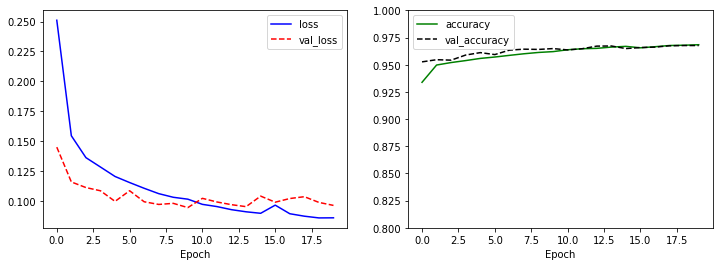

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8,1)
plt.legend()
plt.show()

In [69]:
#라벨 텍스트를 알파벳순으로 정렬
import os
unique_Y =os.listdir(root_dir)
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['as_perm', 'baby_perm', 'balon_perm', 'bob_cut', 'buzz_cut', 'c_curl_perm', 'chuffybang', 'crop_cut', 'dandy_cut', 'dreadlocks', 'foil_perm', 'glam_perm', 'hippie_perm', 'hush_cut', 'layered_cut', 'mohican', 'part_perm', 'pomade', 'wave_perm', 'wolf_cut']


[[0.22804414 0.0011719  0.46384546 ... 0.93561614 0.2713574  0.37000963]]
[[0.27110562 0.1906769  0.2579997  ... 0.02486858 0.01371733 0.01737031]]
[[0.         0.         0.05823999 ... 0.533222   0.         0.6686869 ]]


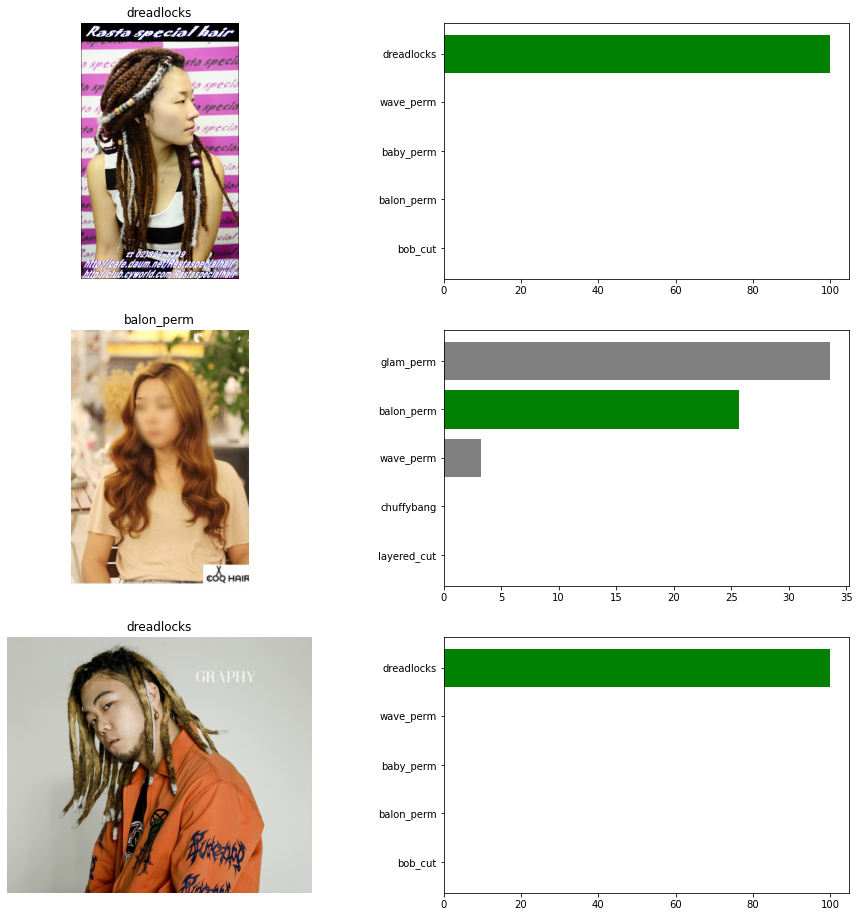

In [95]:
#분류를 시각화
import random
import cv2
plt.figure(figsize=(16,16))
m = load_model('model/5_20_256_selu_selu_selu_sigmoid_resnet_class.h5')
for c in range(3):
    image_path = random.choice(valid_generator.filepaths)
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path, 0))
    real_y = image_path.split('\\')[-2]
    plt.title(real_y)
    plt.axis('off')
    idx = unique_sorted_Y.index(real_y)

    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(224, 224))
    img = img/255.0
    img = np.expand_dims(img, axis=0)

    feature_vector = feature_model.predict(img)
    print(feature_vector)
    prediction = m.predict(feature_vector)[0]
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] *5
    if idx in top_5_predict :
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1]*100, color=color)
    plt.yticks(range(5), labels[::-1])

In [ ]:
model.save('resnet_selu_sigmoid_2.h5')

In [ ]:
image_path = 'D:/data-anal/marytalk/test/a82c33ed7f4e3c95e8be411813e19f6e.jpg'
img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(299, 299))
img = img/255.0
img = np.expand_dims(img, axis=0)

feature_vector = feature_model.predict(img)
print(feature_vector)
prediction = m.predict(feature_vector)[0]
top_5_predict = prediction.argsort()[::-1][:5]
labels = [unique_sorted_Y[index] for index in top_5_predict]
color = ['gray'] *5
if idx in top_5_predict :
    color[top_5_predict.tolist().index(idx)] = 'green'
color = color[::-1]
plt.barh(range(5), prediction[top_5_predict][::-1]*100, color=color)
plt.yticks(range(5), labels[::-1])

## 하나로 모아서 보기

In [ ]:
batch_size= 24
img_size=110
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True
                                   , validation_split=0.15)
root_dir = 'images'
valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
train_generator = train_datagen.flow_from_directory(root_dir, subset='training', batch_size=batch_size, seed=5
                                                    , shuffle=True, class_mode='categorical'
                                                    , target_size=(224,224))
valid_generator = valid_datagen.flow_from_directory(root_dir, subset='validation', batch_size=1, seed=5
                                                    , shuffle=True, class_mode='categorical'
                                                    , target_size=(224,224))
batch_step = (8016*3)//batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0 :
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)

    feature = feature_model.predict(x)
    train_features.extend(feature)

train_features = np.array(train_features)
train_Y = np.array(train_Y)
print(train_features.shape)
print(train_Y.shape)

valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0 :
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)

    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8,1)
plt.legend()
plt.show()

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
  hub.KerasLayer(inception_url, output_shape=(2048, ), trainable=False)                                     
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

In [ ]:

# 모델 저장
MODEL_DIR ='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

# modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
modelpath='./model/resnet-{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath,monitor='val_loss',verbose=1,save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=10)



with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Dense(64, activation='selu', input_shape=(2048,)))
    model.add(Dropout(0.5))
    model.add(Dense(15))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
#     model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.build([224, 224, 3])
    model.summary()

    history = model.fit(train_features, train_Y, 
                        class_weight='balanced',
                        validation_data=(valid_features, valid_Y), 
                        epochs=20, batch_size=32,
                        verbose=1,callbacks=[early_stopping_callback,checkpointer])

In [26]:
import pickle

In [36]:
with open('category.pickle','wb') as f :
    pickle.dump(category, f)

In [37]:
with open('category.pickle','rb') as f :
    c = pickle.load(f)

In [35]:
c[4]

'버즈컷'

In [22]:
category = ['애즈펌', '베이비펌', '발롱펌', '보브컷', '버즈컷', 'C컬펌', '처피뱅', '크롭컷', '댄디컷', '드레드락', '호일펌', '글램펌', '히피펌', '허쉬컷', '레이어드컷', '모히칸', '가르마펌', '포마드', '물결펌', '울프컷']

In [23]:
category

['애즈펌',
 '베이비펌',
 '발롱펌',
 '보브컷',
 '버즈컷',
 'C컬펌',
 '처피뱅',
 '크롭컷',
 '댄디컷',
 '드레드락',
 '호일펌',
 '글램펌',
 '히피펌',
 '허쉬컷',
 '레이어드컷',
 '모히칸',
 '가르마펌',
 '포마드',
 '물결펌',
 '울프컷']